# Graph Node Classification in Pytorch via message passing

---

The goal of this work is to model a Graph Neural Network to perform Node Classification that can fit different non-trivial datasets and possibly real world scenarios. The idea is to try different network structures and model a training function that automatically finds the best configuration of hyperparameters that can fit a certain task.

In [16]:
# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [17]:
# Set device to gpu if available
import torch
device = 'cpu'
if torch.cuda.is_available:
  print('All good, a Gpu is available')
  device = torch.device("cuda:0")  
else:
  print('Please set GPU via Edit -> Notebook Settings.')
  

All good, a Gpu is available


In [18]:
!nvidia-smi

Tue Jun 21 15:17:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Environment configuration and imports
In order to achieve our goal, we need to install some requirements such as the pytorch geometric utils that give access to a variety of implemented classes and functions about GNN

In [19]:
%%capture
def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install -q torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [20]:
torch; print(torch.__version__)

1.11.0+cu113


In [21]:
import networkx as nx
from torch_geometric.utils import to_networkx

from tqdm import tqdm
import time
import math
import random
import torch
import torch.nn.functional as F
import torch.utils.data as data_utils
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

from sklearn.manifold import TSNE

## Reproducibility
When **developing and debugging** Neural Networks is desirable to have a deterministic behaviour. For this reason, we are going to disable all the sources of randomness. Please note that completely reproducible results are not guaranteed across PyTorch releases, individual commits or different platforms. You can find more detailed information at this [page](https://pytorch.org/docs/stable/notes/randomness.html).
Please note that the flag `cudnn.benchmark = False` disable the auto-tuner that selects the optimal set of algorithms for your hardware and usually leads to slower runtime. 

In [22]:
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True        

In [23]:
fix_random(42)

## The dataset
The datasets we will use in the experiments are the ones offered by torch_geometrics, we can explore the list in that [page](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets).

We will also visualize the data and perform some analysis and statistics about their distribution to see if some network structures works better in some scenarios with respect tot other.

In [24]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root=".", name="Cora", split="full")

In [25]:
data = dataset[0]

In [29]:
import torch_geometric.transforms as T

transform = T.Compose([
    T.NormalizeFeatures()
])
data = transform(data)

from torch_geometric.utils import sort_edge_index
data.edge_index = sort_edge_index(data.edge_index, sort_by_row=False)

In [30]:
print()
print(f'Dataset: {dataset}:')
print('==================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print()
print(data)
print('===============================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
avg_degree = data.num_edges // data.num_nodes
print(f'Average node degree: {avg_degree}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3
Number of training nodes: 1208
Training node label rate: 0.446
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Let's see if class are balanced across the splits:

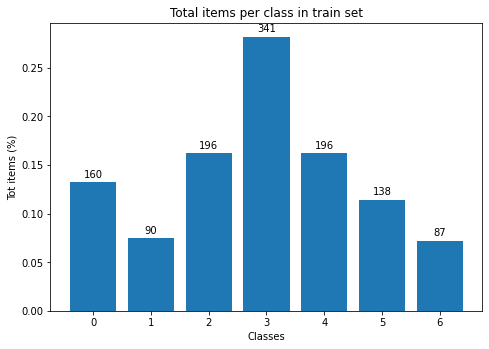

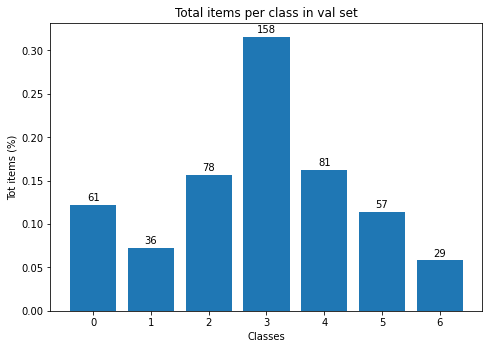

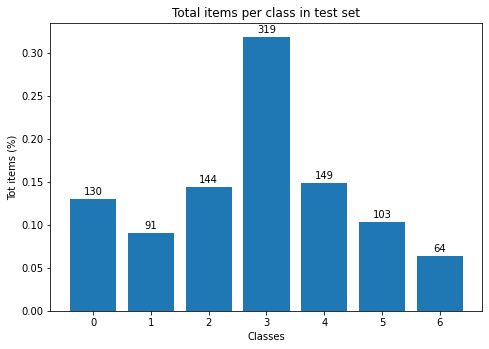

In [31]:
def plot_total_per_class(dataset, split):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    classes = [c for c in range(dataset.num_classes)]
    totals = [0 for c in range(dataset.num_classes)]

    for i in range(len(dataset)):
        graph = dataset[i]
        split_mask = {
        'train' : graph.train_mask,
        'val': graph.val_mask,
        'test': graph.test_mask,
        }
        items = [graph.y[split_mask[split]].tolist().count(i) for i in classes ]
        totals = [x + y for x, y in zip(totals, items)]

    normalized_totals = [float(x) / np.sum(totals) for x in totals]
    bars = ax.bar(classes, normalized_totals)

    for i, bar in enumerate(bars):
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + .005, totals[i], ha='center')

    plt.xlabel('Classes')
    plt.ylabel('Tot items (%)')
    plt.title(f"Total items per class in {split} set")
    plt.show()

for split in ['train', 'val', 'test']:
    plot_total_per_class(dataset, split)

Let's plot the structure of the first graph in the dataset:

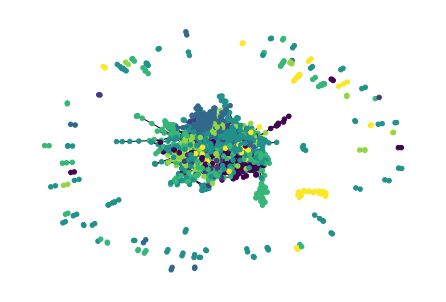

In [15]:
G = to_networkx(data, to_undirected=True)
nx.draw(G, node_color=data.y, node_size=20)

# Train and Evaluation

In [32]:
data = data.to(device)

In [33]:
def train(model, optimizer):
    model.train()

    total_loss = total_examples = 0

    optimizer.zero_grad()

    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

    loss.backward()
    optimizer.step()
    
    return loss, out

In [34]:
@torch.no_grad()
def test(model):
    model.eval()

    out = model(data.x, data.edge_index)

    y_true = data.y
    y_pred = out.argmax(dim=-1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = y_pred[mask].eq(y_true[mask]).sum().item()
        accs.append(correct / mask.sum().item())
    return accs

In [35]:
def train_eval(model, optimizer, trials=1, epochs=20):

    print('Train: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    start_time_sec = time.time()

    best_model_weights = None
    best_model_history = None
    best_model_embeddings = None

    best_test_acc = 0

    for trial in range(trials):

        model.reset_parameters()

        last_val_acc = 0

        history = {}
        history['train_loss'] = []
        history['train_acc'] = []
        history['val_acc'] = []
        history['test_acc'] = []

        embeddings = []

        pbar = tqdm(range(epochs))
        for epoch in pbar:

            loss, yhat = train(model, optimizer)
            embeddings.append(yhat)

            accs = test(model)

            description = f'Epoch: {epoch+1:02d}, Train loss: {loss:.4f}, Train acc: {accs[0]:.4f}, Val acc: {accs[1]:.4f}, Test acc: {accs[2]:.4f}'
            pbar.set_description(description, refresh=True)


            history['train_loss'].append(loss)
            history['train_acc'].append(accs[0])
            history['val_acc'].append(accs[1])
            history['test_acc'].append(accs[2])

            last_test_acc = history['test_acc'][-1]
            if last_test_acc > best_test_acc:
                best_test_acc = last_test_acc
                best_model_weights = model.state_dict()
                best_model_history = history
                best_model_embeddings = embeddings

        # END OF TRAINING LOOP
    # END OF TRIALS LOOP
    print(f'\nBest model with test acc: {best_test_acc:.4f}')

    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    print()
    print('Time total:     %5.2f sec' % (total_time_sec))

    return best_model_history, best_model_weights, best_model_embeddings

#Models definition
In the following sections we are going to perform several experiments using different model structures 

In [36]:
# Shared global variables
INPUT_DIM = dataset.num_features
OUTPUT_DIM = dataset.num_classes
EPOCHS = 200
NTRIALS = 1
LR = 1e-3
WD = 1e-5

## Experiment #1: GCN

In the first experiment we deal with a Graph Convolutional Network based on [Message Passing](https://arxiv.org/abs/1704.01212).

Here the GCN is matematically defined as:
$$x_{i}^{(k)} = \sum_{j \in \mathcal{N(i)} \cup \{i\}} \frac{1}{\sqrt{\deg(i)} \cdot \sqrt{\deg(j)}} \cdot \left(  \Theta^{\top} \cdot x_{j}^{(k-1)}\right)$$
where neighboring node features are first transformed by a weight matrix $\Theta$, normalized by their degree, and finally summed up. This formula can be divided into the following steps:
1. Add self-loops to the adjacency matrix.
2. Linearly transform node feature matrix.
3. Compute normalization coefficients.
4. Normalize node features in $\phi$.
5. Sum up neighboring node features ("add" aggregation).

Source: [pytorch geometric documentation](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html)

In [37]:
from torch_geometric.nn.conv import GCNConv
from torch.nn import Sequential, Linear, Dropout
from torch_geometric.nn.norm import BatchNorm

class GCN(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, p_drop=0.5, n_layers=2, skip_conn=False, post_proc_MLP=False, return_embedding=False):
        super(GCN, self).__init__()

        if n_layers < 1:
            raise AssertionError('Number or convolution layer must be at least 1')

        self.p_drop = p_drop
        self.n_layers = n_layers
        self.skip_conn = skip_conn
        self.return_embedding = return_embedding

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        for i in range(n_layers):
            conv = GCNConv(in_dim, hid_dim)
            in_dim = hid_dim
            bn = BatchNorm(in_dim)
            self.convs.append(conv)
            self.bns.append(bn)
            
        self.post_proc_MLP = post_proc_MLP
        if post_proc_MLP:
            self.post_MLP = Sequential(
                Linear(in_dim, hid_dim),
                Dropout(self.p_drop),
                Linear(hid_dim, out_dim)
            )
        else:
            self.convs[-1] = GCNConv(in_dim, out_dim)
            self.bns[-1] = BatchNorm(out_dim)


    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, edge_index):
        x_prev = None
        for (conv, bn) in zip(self.convs[:-1], self.bns[:-1]):
            x = conv(x, edge_index)
            x = bn(x)

            if self.skip_conn and x_prev is not None:
                x = x + x_prev
            
            x = F.relu(x)
            x = F.dropout(x, p=self.p_drop, training=self.training)
            x_prev = x
            
        if self.post_proc_MLP:
            x = self.convs[-1](x, edge_index)
            x = self.bns[-1](x)
            embedding = x
            x = self.post_MLP(x)
        else:
            embedding = x
            x = self.convs[-1](x, edge_index)
            x = self.bns[-1](x)

        prediction = F.log_softmax(x, dim=1)

        if self.return_embedding:
            return prediction, embedding
        else:
            return prediction

In [38]:
best_test_acc = 0
best_model_history = None
best_model_weight = None
best_model_embeddings = None


from sklearn.model_selection import ParameterGrid
configs = {
    'HIDDEN_DIM' : [16],
    'DROPOUT' : [0.3],
    'N_LAYERS' : [3],
    'SKIP_CONN' : [False, True],
    'POST_PROC_MLP' : [False, True]
}
param_grid = ParameterGrid(configs)
print(f'Number of combinations: {len(param_grid)}')
print('------------------')
for dict_ in param_grid:
    print(f'Trying configuration {dict_}')
    model = GCN(INPUT_DIM, dict_['HIDDEN_DIM'], OUTPUT_DIM, dict_['DROPOUT'], dict_['N_LAYERS'], dict_['SKIP_CONN'], dict_['POST_PROC_MLP']).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
    history, weights, embeddings = train_eval(model, optimizer, trials=NTRIALS, epochs=EPOCHS)

    print('------------------')

    if max(history['test_acc']) > best_test_acc:
        best_test_acc = max(history['test_acc'])
        best_parameters = dict_
        best_model_history = history
        best_model_weights = weights
        best_model_embeddings = embeddings

Number of combinations: 4
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': False}
Train: model=GCN, opt=Adam(lr=0.001000), epochs=200, device=cuda:0



Epoch: 200, Train loss: 0.4526, Train acc: 0.9594, Val acc: 0.8140, Test acc: 0.7980: 100%|██████████| 200/200 [00:02<00:00, 71.57it/s]



Best model with test acc: 0.8190

Time total:      2.80 sec
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}
Train: model=GCN, opt=Adam(lr=0.001000), epochs=200, device=cuda:0



Epoch: 200, Train loss: 0.4422, Train acc: 0.9661, Val acc: 0.7940, Test acc: 0.8010: 100%|██████████| 200/200 [00:02<00:00, 69.06it/s]



Best model with test acc: 0.8160

Time total:      2.90 sec
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': False}
Train: model=GCN, opt=Adam(lr=0.001000), epochs=200, device=cuda:0



Epoch: 200, Train loss: 0.1903, Train acc: 0.9727, Val acc: 0.8360, Test acc: 0.8040: 100%|██████████| 200/200 [00:02<00:00, 67.21it/s]



Best model with test acc: 0.8370

Time total:      2.99 sec
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}
Train: model=GCN, opt=Adam(lr=0.001000), epochs=200, device=cuda:0



Epoch: 200, Train loss: 0.2008, Train acc: 0.9743, Val acc: 0.8060, Test acc: 0.8110: 100%|██████████| 200/200 [00:03<00:00, 66.64it/s]


Best model with test acc: 0.8350

Time total:      3.01 sec
------------------


In [39]:
print(f'Best parameters: {best_parameters}')
model = GCN(INPUT_DIM, best_parameters['HIDDEN_DIM'], OUTPUT_DIM, best_parameters['DROPOUT'], best_parameters['N_LAYERS'], best_parameters['SKIP_CONN'], best_parameters['POST_PROC_MLP'])
model.load_state_dict(best_model_weights)
print()
print(f'Best model predicts with {best_test_acc*100:.2f}% accuracy on test set')

Best parameters: {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': False}

Best model predicts with 83.70% accuracy on test set


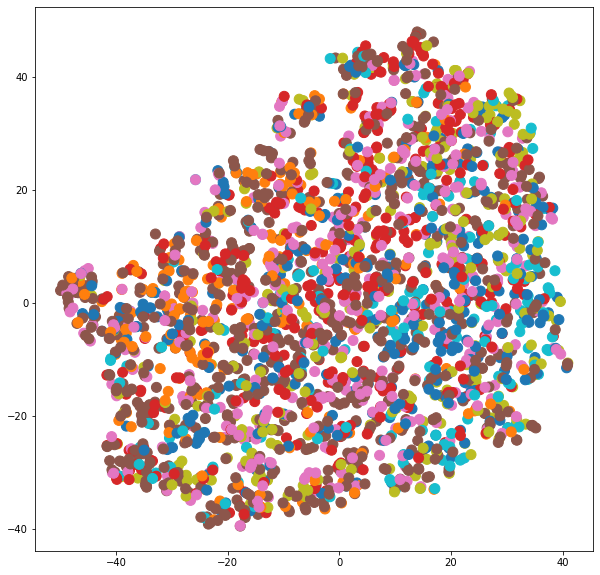

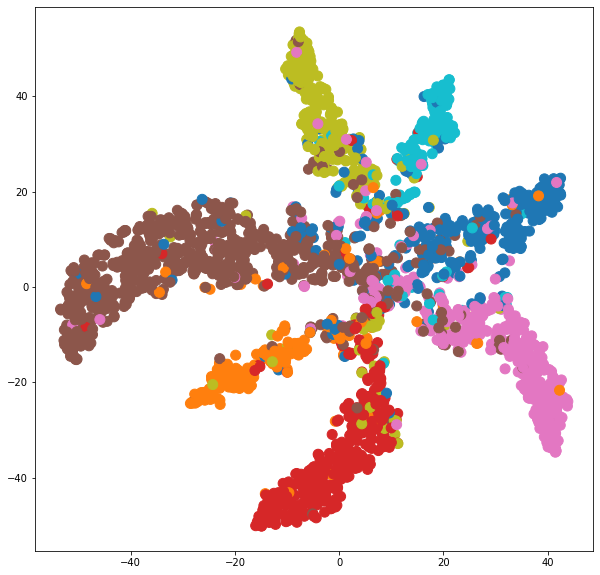

In [40]:
def plot_embedding2D(h, color=data.y, size=100):
    h = h.cpu().detach().numpy()
    h = TSNE(n_components=2, perplexity=30, n_iter=500, verbose=False).fit_transform(h)
    fig = plt.figure(figsize=(10, 10))
    plt.set_cmap("tab10")
    plt.scatter(h[:, 0], h[:, 1], c=color.cpu(), s=size)
    plt.show()

# Embedding beore training
plot_embedding2D(best_model_embeddings[0])
# Embedding after training
plot_embedding2D(best_model_embeddings[-1])

## Experiment #2: SAGE

GraphSage extends the GCN in two main aspects. First, the aggregation function over the neighbors is no longer costrained to a normalized sum but it can arbitrary choosen. Then the message is concatenated with the new node state instead of be summed.
Type of aggregation can be:
- mean: $AGG = \sum_{j \in \mathcal{N}(i)} \frac{x_j}{|\mathcal{N}(i)|}$
- pool: $AGG = \text{MEAN}( \Theta^\top \cdot x_j )$ or aternatively $\text{ADD}$
- lstm: $AGG = LSTM([x_j, \forall j \in \pi(\mathcal{N}(i)])$ where $\pi$ means shuffling

$$x_{i}^{k} = \Theta \cdot \text{CONCAT}\left( x_{i}^{(k-1)}, \text{AGG}_{j \in \mathcal{N}(i)} x_{j}^{(k-1)}\right)$$

The following implemetation implements the **mean** aggregation:

In [41]:
from torch_geometric.nn.conv import SAGEConv
from torch.nn import Sequential, Linear, Dropout
from torch_geometric.nn.norm import BatchNorm

class SAGE(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, p_drop=0.5, n_layers=2, aggr="add", skip_conn=False, post_proc_MLP=False, return_embedding=False):
        super(SAGE, self).__init__()

        if n_layers < 1:
            raise AssertionError('Number or convolution layer must be at least 1')

        self.p_drop = p_drop
        self.n_layers = n_layers
        self.skip_conn = skip_conn
        self.return_embedding = return_embedding
        self.aggr = aggr

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        for i in range(n_layers):
            conv = SAGEConv(in_dim, hid_dim, aggr=self.aggr, normalize=True)
            in_dim = hid_dim
            bn = BatchNorm(in_dim)
            self.convs.append(conv)
            self.bns.append(bn)
            
        self.post_proc_MLP = post_proc_MLP
        if post_proc_MLP:
            self.post_MLP = Sequential(
                Linear(in_dim, hid_dim),
                Dropout(self.p_drop),
                Linear(hid_dim, out_dim)
            )
        else:
            self.convs[-1] = SAGEConv(in_dim, out_dim, aggr=self.aggr, normalize=True)
            self.bns[-1] = BatchNorm(out_dim)


    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, edge_index):
        x_prev = None
        for (conv, bn) in zip(self.convs[:-1], self.bns[:-1]):
            x = conv(x, edge_index)
            x = bn(x)

            if self.skip_conn and x_prev is not None:
                x = x + x_prev
            
            x = F.relu(x)
            x = F.dropout(x, p=self.p_drop, training=self.training)
            x_prev = x
            
        if self.post_proc_MLP:
            x = self.convs[-1](x, edge_index)
            x = self.bns[-1](x)
            embedding = x
            x = self.post_MLP(x)
        else:
            embedding = x
            x = self.convs[-1](x, edge_index)
            x = self.bns[-1](x)

        prediction = F.log_softmax(x, dim=1)

        if self.return_embedding:
            return prediction, embedding
        else:
            return prediction

In [43]:
best_test_acc = 0
best_model_history = None
best_model_weight = None
best_model_embeddings = None


from sklearn.model_selection import ParameterGrid
configs = {
    'HIDDEN_DIM' : [16],
    'DROPOUT' : [0.3],
    'N_LAYERS' : [3],
    'AGGR' : ["add", "mean", "max"], #, "lstm"
    'SKIP_CONN' : [False, True],
    'POST_PROC_MLP' : [False, True]
}
param_grid = ParameterGrid(configs)
print(f'Number of combinations: {len(param_grid)}')
print('------------------')
for dict_ in param_grid:
    print(f'Trying configuration {dict_}')
    model = SAGE(INPUT_DIM, dict_['HIDDEN_DIM'], OUTPUT_DIM, dict_['DROPOUT'], dict_['N_LAYERS'], dict_['AGGR'], dict_['SKIP_CONN'], dict_['POST_PROC_MLP']).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
    history, weights, embeddings = train_eval(model, optimizer, trials=NTRIALS, epochs=EPOCHS)

    print('------------------')

    if max(history['test_acc']) > best_test_acc:
        best_test_acc = max(history['test_acc'])
        best_parameters = dict_
        best_model_history = history
        best_model_weights = weights
        best_model_embeddings = embeddings

Number of combinations: 12
------------------
Trying configuration {'AGGR': 'add', 'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': False}
Train: model=SAGE, opt=Adam(lr=0.001000), epochs=200, device=cuda:0



Epoch: 200, Train loss: 0.3308, Train acc: 0.9934, Val acc: 0.7980, Test acc: 0.7740: 100%|██████████| 200/200 [00:03<00:00, 53.55it/s]



Best model with test acc: 0.8170

Time total:      3.74 sec
------------------
Trying configuration {'AGGR': 'add', 'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}
Train: model=SAGE, opt=Adam(lr=0.001000), epochs=200, device=cuda:0



Epoch: 200, Train loss: 0.3255, Train acc: 0.9934, Val acc: 0.7640, Test acc: 0.7820: 100%|██████████| 200/200 [00:04<00:00, 49.70it/s]



Best model with test acc: 0.8190

Time total:      4.04 sec
------------------
Trying configuration {'AGGR': 'add', 'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': False}
Train: model=SAGE, opt=Adam(lr=0.001000), epochs=200, device=cuda:0



Epoch: 200, Train loss: 0.1280, Train acc: 0.9992, Val acc: 0.8320, Test acc: 0.8150: 100%|██████████| 200/200 [00:04<00:00, 42.05it/s]



Best model with test acc: 0.8330

Time total:      4.77 sec
------------------
Trying configuration {'AGGR': 'add', 'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}
Train: model=SAGE, opt=Adam(lr=0.001000), epochs=200, device=cuda:0



Epoch: 200, Train loss: 0.1184, Train acc: 0.9992, Val acc: 0.8300, Test acc: 0.8250: 100%|██████████| 200/200 [00:03<00:00, 66.16it/s]



Best model with test acc: 0.8400

Time total:      3.04 sec
------------------
Trying configuration {'AGGR': 'mean', 'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': False}
Train: model=SAGE, opt=Adam(lr=0.001000), epochs=200, device=cuda:0



Epoch: 200, Train loss: 0.3064, Train acc: 0.9975, Val acc: 0.7780, Test acc: 0.7730: 100%|██████████| 200/200 [00:02<00:00, 78.36it/s]



Best model with test acc: 0.8290

Time total:      2.56 sec
------------------
Trying configuration {'AGGR': 'mean', 'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}
Train: model=SAGE, opt=Adam(lr=0.001000), epochs=200, device=cuda:0



Epoch: 200, Train loss: 0.2832, Train acc: 0.9983, Val acc: 0.6940, Test acc: 0.6870: 100%|██████████| 200/200 [00:02<00:00, 79.05it/s]



Best model with test acc: 0.7320

Time total:      2.54 sec
------------------
Trying configuration {'AGGR': 'mean', 'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': False}
Train: model=SAGE, opt=Adam(lr=0.001000), epochs=200, device=cuda:0



Epoch: 200, Train loss: 0.1110, Train acc: 0.9983, Val acc: 0.8320, Test acc: 0.8190: 100%|██████████| 200/200 [00:02<00:00, 74.17it/s]



Best model with test acc: 0.8350

Time total:      2.71 sec
------------------
Trying configuration {'AGGR': 'mean', 'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}
Train: model=SAGE, opt=Adam(lr=0.001000), epochs=200, device=cuda:0



Epoch: 200, Train loss: 0.1315, Train acc: 0.9992, Val acc: 0.8040, Test acc: 0.7990: 100%|██████████| 200/200 [00:02<00:00, 73.81it/s]



Best model with test acc: 0.8180

Time total:      2.72 sec
------------------
Trying configuration {'AGGR': 'max', 'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': False}
Train: model=SAGE, opt=Adam(lr=0.001000), epochs=200, device=cuda:0



Epoch: 200, Train loss: 0.3138, Train acc: 0.9983, Val acc: 0.7500, Test acc: 0.7540: 100%|██████████| 200/200 [00:02<00:00, 69.84it/s]



Best model with test acc: 0.7900

Time total:      2.88 sec
------------------
Trying configuration {'AGGR': 'max', 'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}
Train: model=SAGE, opt=Adam(lr=0.001000), epochs=200, device=cuda:0



Epoch: 200, Train loss: 0.2883, Train acc: 0.9983, Val acc: 0.7260, Test acc: 0.7580: 100%|██████████| 200/200 [00:02<00:00, 69.26it/s]



Best model with test acc: 0.8230

Time total:      2.90 sec
------------------
Trying configuration {'AGGR': 'max', 'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': False}
Train: model=SAGE, opt=Adam(lr=0.001000), epochs=200, device=cuda:0



Epoch: 200, Train loss: 0.1239, Train acc: 1.0000, Val acc: 0.8460, Test acc: 0.8090: 100%|██████████| 200/200 [00:03<00:00, 64.00it/s]



Best model with test acc: 0.8180

Time total:      3.14 sec
------------------
Trying configuration {'AGGR': 'max', 'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}
Train: model=SAGE, opt=Adam(lr=0.001000), epochs=200, device=cuda:0



Epoch: 200, Train loss: 0.1143, Train acc: 0.9992, Val acc: 0.8120, Test acc: 0.8050: 100%|██████████| 200/200 [00:03<00:00, 66.34it/s]


Best model with test acc: 0.8350

Time total:      3.02 sec
------------------


In [44]:
print(f'Best parameters: {best_parameters}')
model = SAGE(INPUT_DIM, best_parameters['HIDDEN_DIM'], OUTPUT_DIM, best_parameters['DROPOUT'], best_parameters['N_LAYERS'], best_parameters['AGGR'], best_parameters['SKIP_CONN'], best_parameters['POST_PROC_MLP'])
model.load_state_dict(best_model_weights)
print()
print(f'Best model predicts with {best_test_acc*100:.2f}% accuracy on test set')

Best parameters: {'AGGR': 'add', 'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}

Best model predicts with 84.00% accuracy on test set


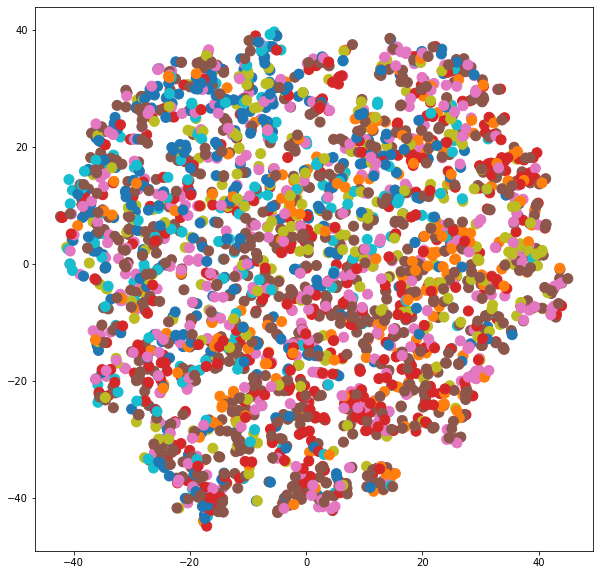

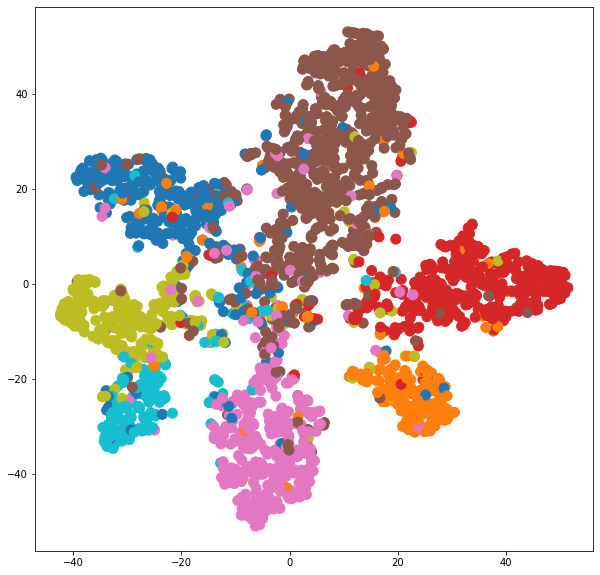

In [45]:
def plot_embedding2D(h, color=data.y, size=100):
    h = h.cpu().detach().numpy()
    h = TSNE(n_components=2, perplexity=30, n_iter=500, verbose=False).fit_transform(h)
    fig = plt.figure(figsize=(10, 10))
    plt.set_cmap("tab10")
    plt.scatter(h[:, 0], h[:, 1], c=color.cpu(), s=size)
    plt.show()

# Embedding beore training
plot_embedding2D(best_model_embeddings[0])
# Embedding after training
plot_embedding2D(best_model_embeddings[-1])

## Experiment #3: GAT



Popular GNN architectures weigh all neighbors $j \in N_{i}$ with equal importance (e.g., mean or max-pooling as AGGREGATE). To
address this limitation, GAT computes a score
for every edge $(j, i)$, which indicates the importance of the features of the neighbor $j$ to the node $i$.

GAT convolution is matematically defined as:

$$ x_{i}^{'} = \alpha_{i,j} \Theta x_{i} + \sum_{j \in \mathcal{N}(i)} \alpha_{i,j} \Theta x_{j}$$

the scoring function is defined as:

$$ e(x_{i}, x_{j}) =  \text{LeakyReLU}(a^\top \cdot [\Theta x_{i} || \Theta x_{j}]) $$

and is used to compute the attention coefficients:

$$ \alpha_{i,j} = \text{softmax}_{j}(e(x_{i}, x_{j})) =  \frac{\exp(e(x_{i}, x_{j}))}{\sum_{j^{'} \in \mathcal{N}} \exp(e(x_{i}, x_{j^{'}}))} $$


The main problem in the standard GAT scoring function  is that the learned layers $\Theta$ and $a$ are applied consecutively, and thus can be collapsed into a single linear layer. To fix
this limitation, in GATv2 the $a$ layer is applied after the nonlinearity (LeakyReLU), and the $\Theta$ layer
after the concatenation, effectively applying an MLP to compute the score for each query-key pair:

$$ e(x_{i}, x_{j}) =  a^\top \text{LeakyReLU}(\Theta \cdot [x_{i} ||  x_{j}]) $$

In [46]:
from torch_geometric.nn.conv import GATv2Conv
from torch.nn import Sequential, Linear, Dropout
from torch_geometric.nn.norm import BatchNorm

class GATv2(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, p_drop=0.5, n_layers=2, n_heads=3, skip_conn=False, post_proc_MLP=False, return_embedding=False):
        super(GATv2, self).__init__()

        if n_layers < 1:
            raise AssertionError('Number or convolution layer must be at least 1')

        self.p_drop = p_drop
        self.n_layers = n_layers
        self.skip_conn = skip_conn
        self.return_embedding = return_embedding

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        for i in range(n_layers):
            conv = GATv2Conv(in_dim, hid_dim, heads=n_heads, concat=True)
            in_dim = hid_dim * n_heads
            bn = BatchNorm(in_dim)
            self.convs.append(conv)
            self.bns.append(bn)
            
        self.post_proc_MLP = post_proc_MLP
        if post_proc_MLP:
            self.post_MLP = Sequential(
                Linear(in_dim, hid_dim), Dropout(self.p_drop),
                Linear(hid_dim, out_dim)
            )
        else:
            self.convs[-1] = GATv2Conv(in_dim, out_dim, heads=n_heads, concat=False)
            self.bns[-1] = BatchNorm(out_dim)


    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, edge_index):
        x_prev = None
        for (conv, bn) in zip(self.convs[:-1], self.bns[:-1]):
            x = conv(x, edge_index)
            x = bn(x)

            if self.skip_conn and x_prev is not None:
                x = x + x_prev
            
            x = F.relu(x)
            x = F.dropout(x, p=self.p_drop, training=self.training)
            x_prev = x
            
        if self.post_proc_MLP:
            x = self.convs[-1](x, edge_index)
            x = self.bns[-1](x)
            embedding = x
            x = self.post_MLP(x)
        else:
            embedding = x
            x = self.convs[-1](x, edge_index)
            x = self.bns[-1](x)

        prediction = F.log_softmax(x, dim=1)

        if self.return_embedding:
            return prediction, embedding
        else:
            return prediction

In [58]:
best_test_acc = 0
best_model_history = None
best_model_weight = None
best_model_embeddings = None


from sklearn.model_selection import ParameterGrid
configs = {
    'HIDDEN_DIM' : [16],
    'DROPOUT' : [0.3],
    'N_LAYERS' : [3],
    'N_HEADS' : [8],
    'SKIP_CONN' : [False, True],
    'POST_PROC_MLP' : [False, True]
}
param_grid = ParameterGrid(configs)
print(f'Number of combinations: {len(param_grid)}')
print('------------------')
for dict_ in param_grid:
    print(f'Trying configuration {dict_}')
    model = GATv2(INPUT_DIM, dict_['HIDDEN_DIM'], OUTPUT_DIM, dict_['DROPOUT'], dict_['N_LAYERS'], dict_['N_HEADS'], dict_['SKIP_CONN'], dict_['POST_PROC_MLP']).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
    history, weights, embeddings = train_eval(model, optimizer, trials=NTRIALS, epochs=EPOCHS)

    print('------------------')

    if max(history['test_acc']) > best_test_acc:
        best_test_acc = max(history['test_acc'])
        best_parameters = dict_
        best_model_history = history
        best_model_weights = weights
        best_model_embeddings = embeddings

Number of combinations: 4
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': False}
Train: model=GATv2, opt=Adam(lr=0.001000), epochs=200, device=cuda:0



Epoch: 200, Train loss: 0.2200, Train acc: 0.9959, Val acc: 0.7680, Test acc: 0.7610: 100%|██████████| 200/200 [00:03<00:00, 53.55it/s]



Best model with test acc: 0.7980

Time total:      3.74 sec
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}
Train: model=GATv2, opt=Adam(lr=0.001000), epochs=200, device=cuda:0



Epoch: 200, Train loss: 0.2112, Train acc: 0.9975, Val acc: 0.7620, Test acc: 0.7650: 100%|██████████| 200/200 [00:03<00:00, 53.36it/s]



Best model with test acc: 0.8110

Time total:      3.76 sec
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': False}
Train: model=GATv2, opt=Adam(lr=0.001000), epochs=200, device=cuda:0



Epoch: 200, Train loss: 0.0181, Train acc: 0.9975, Val acc: 0.8220, Test acc: 0.7950: 100%|██████████| 200/200 [00:03<00:00, 50.72it/s]



Best model with test acc: 0.8280

Time total:      3.95 sec
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}
Train: model=GATv2, opt=Adam(lr=0.001000), epochs=200, device=cuda:0



Epoch: 200, Train loss: 0.0142, Train acc: 0.9992, Val acc: 0.8360, Test acc: 0.8200: 100%|██████████| 200/200 [00:03<00:00, 50.81it/s]


Best model with test acc: 0.8400

Time total:      3.95 sec
------------------


In [59]:
print(f'Best parameters: {best_parameters}')
model = GATv2(INPUT_DIM, best_parameters['HIDDEN_DIM'], OUTPUT_DIM, best_parameters['DROPOUT'], best_parameters['N_LAYERS'], dict_['N_HEADS'], best_parameters['SKIP_CONN'], best_parameters['POST_PROC_MLP'])
model.load_state_dict(best_model_weights)
print()
print(f'Best model predicts with {best_test_acc*100:.2f}% accuracy on test set')

Best parameters: {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}

Best model predicts with 84.00% accuracy on test set


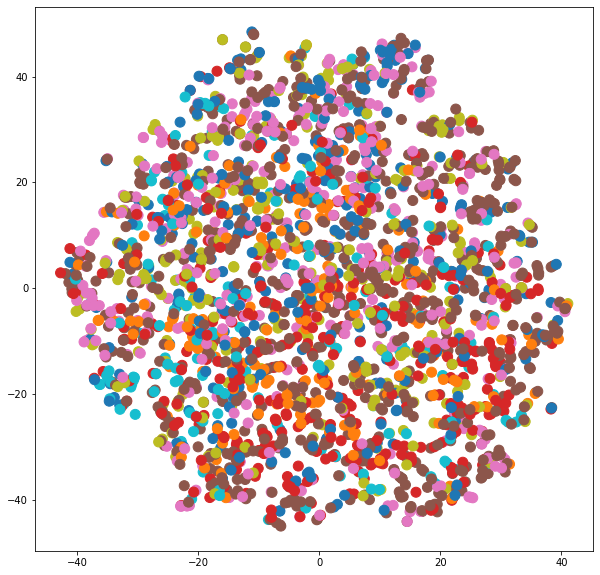

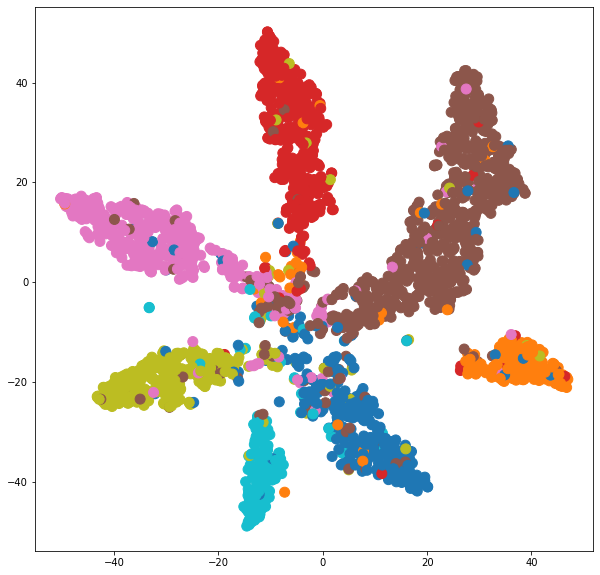

In [60]:
def plot_embedding2D(h, color=data.y, size=100):
    h = h.cpu().detach().numpy()
    h = TSNE(n_components=2, perplexity=30, n_iter=500, verbose=False).fit_transform(h)
    fig = plt.figure(figsize=(10, 10))
    plt.set_cmap("tab10")
    plt.scatter(h[:, 0], h[:, 1], c=color.cpu(), s=size)
    plt.show()

# Embedding beore training
plot_embedding2D(best_model_embeddings[0])
# Embedding after training
plot_embedding2D(best_model_embeddings[-1])

## Experiment #4: GIN



In [50]:
from torch_geometric.nn.conv import GINConv
from torch.nn import Sequential, Linear, Dropout
from torch_geometric.nn.norm import BatchNorm

def build_MLP(in_dim, hid_dim, out_dim):
    return Sequential(
        Linear(in_dim, hid_dim),
        Dropout(0.2),
        Linear(hid_dim, out_dim)
    )

class GIN(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, p_drop=0.5, n_layers=2, skip_conn=False, post_proc_MLP=False, return_embedding=False):
        super(GIN, self).__init__()

        if n_layers < 1:
            raise AssertionError('Number or convolution layer must be at least 1')

        self.p_drop = p_drop
        self.n_layers = n_layers
        self.skip_conn = skip_conn
        self.return_embedding = return_embedding

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        for i in range(n_layers):
            conv = GINConv(build_MLP(in_dim, 500, hid_dim))
            in_dim = hid_dim
            bn = BatchNorm(in_dim)
            self.convs.append(conv)
            self.bns.append(bn)
            
        self.post_proc_MLP = post_proc_MLP
        if post_proc_MLP:
            self.post_MLP = Sequential(
                Linear(in_dim, hid_dim),
                Dropout(self.p_drop),
                Linear(hid_dim, out_dim)
            )
        else:
            self.convs[-1] = GINConv(build_MLP(in_dim, 500, out_dim))
            self.bns[-1] = BatchNorm(out_dim)


    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, edge_index):
        x_prev = None
        for (conv, bn) in zip(self.convs[:-1], self.bns[:-1]):
            x = conv(x, edge_index)
            x = bn(x)

            if self.skip_conn and x_prev is not None:
                x = x + x_prev
            
            x = F.relu(x)
            x = F.dropout(x, p=self.p_drop, training=self.training)
            x_prev = x
            
        if self.post_proc_MLP:
            x = self.convs[-1](x, edge_index)
            x = self.bns[-1](x)
            embedding = x
            x = self.post_MLP(x)
        else:
            embedding = x
            x = self.convs[-1](x, edge_index)
            x = self.bns[-1](x)

        prediction = F.log_softmax(x, dim=1)

        if self.return_embedding:
            return prediction, embedding
        else:
            return prediction

In [51]:
best_test_acc = 0
best_model_history = None
best_model_weight = None
best_model_embeddings = None


from sklearn.model_selection import ParameterGrid
configs = {
    'HIDDEN_DIM' : [16],
    'DROPOUT' : [0.3],
    'N_LAYERS' : [3],
    'SKIP_CONN' : [False, True],
    'POST_PROC_MLP' : [False, True]
}
param_grid = ParameterGrid(configs)
print(f'Number of combinations: {len(param_grid)}')
print('------------------')
for dict_ in param_grid:
    print(f'Trying configuration {dict_}')
    model = GIN(INPUT_DIM, dict_['HIDDEN_DIM'], OUTPUT_DIM, dict_['DROPOUT'], dict_['N_LAYERS'], dict_['SKIP_CONN'], dict_['POST_PROC_MLP']).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
    history, weights, embeddings = train_eval(model, optimizer, trials=NTRIALS, epochs=EPOCHS)

    print('------------------')

    if max(history['test_acc']) > best_test_acc:
        best_test_acc = max(history['test_acc'])
        best_parameters = dict_
        best_model_history = history
        best_model_weights = weights
        best_model_embeddings = embeddings

Number of combinations: 4
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': False}
Train: model=GIN, opt=Adam(lr=0.001000), epochs=200, device=cuda:0



Epoch: 200, Train loss: 0.4814, Train acc: 0.9627, Val acc: 0.7660, Test acc: 0.7660: 100%|██████████| 200/200 [00:02<00:00, 72.71it/s]



Best model with test acc: 0.8270

Time total:      2.76 sec
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}
Train: model=GIN, opt=Adam(lr=0.001000), epochs=200, device=cuda:0



Epoch: 200, Train loss: 0.4447, Train acc: 0.9719, Val acc: 0.7580, Test acc: 0.7450: 100%|██████████| 200/200 [00:02<00:00, 73.21it/s]



Best model with test acc: 0.8400

Time total:      2.74 sec
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': False}
Train: model=GIN, opt=Adam(lr=0.001000), epochs=200, device=cuda:0



Epoch: 200, Train loss: 0.2499, Train acc: 0.9776, Val acc: 0.7880, Test acc: 0.7880: 100%|██████████| 200/200 [00:02<00:00, 70.42it/s]



Best model with test acc: 0.8090

Time total:      2.85 sec
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}
Train: model=GIN, opt=Adam(lr=0.001000), epochs=200, device=cuda:0



Epoch: 200, Train loss: 0.2252, Train acc: 0.9859, Val acc: 0.8040, Test acc: 0.7920: 100%|██████████| 200/200 [00:02<00:00, 70.06it/s]


Best model with test acc: 0.8220

Time total:      2.87 sec
------------------


In [52]:
print(f'Best parameters: {best_parameters}')
model = GIN(INPUT_DIM, best_parameters['HIDDEN_DIM'], OUTPUT_DIM, best_parameters['DROPOUT'], best_parameters['N_LAYERS'], best_parameters['SKIP_CONN'], best_parameters['POST_PROC_MLP'])
model.load_state_dict(best_model_weights)
print()
print(f'Best model predicts with {best_test_acc*100:.2f}% accuracy on test set')

Best parameters: {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}

Best model predicts with 84.00% accuracy on test set


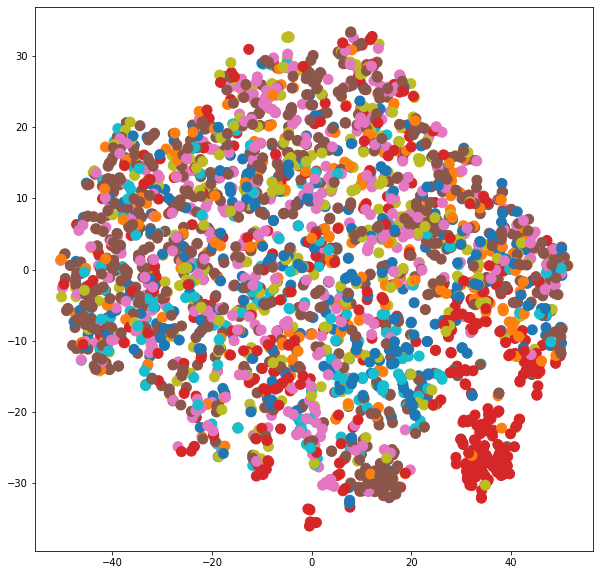

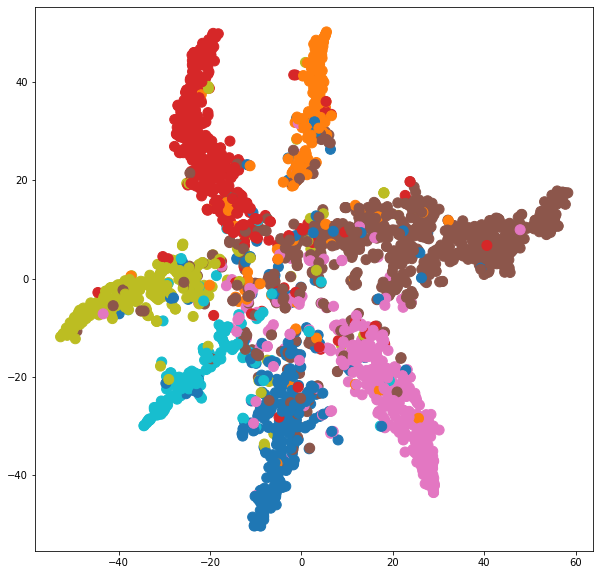

In [53]:
def plot_embedding2D(h, color=data.y, size=100):
    h = h.cpu().detach().numpy()
    h = TSNE(n_components=2, perplexity=30, n_iter=500, verbose=False).fit_transform(h)
    fig = plt.figure(figsize=(10, 10))
    plt.set_cmap("tab10")
    plt.scatter(h[:, 0], h[:, 1], c=color.cpu(), s=size)
    plt.show()

# Embedding beore training
plot_embedding2D(best_model_embeddings[0])
# Embedding after training
plot_embedding2D(best_model_embeddings[-1])

# Plotting animations

The following function is used to have an animation of how the learning process work and the embeddings in 2d space evolve

In [54]:
def animate(i):
    ax.clear()
    h = best_model_embeddings[i]
    h = h.cpu().detach().numpy()
    h = TSNE(n_components=2, perplexity=30, n_iter=500, verbose=False).fit_transform(h)
    ax.scatter(h[:, 0], h[:, 1], c=data.y.cpu(), s=100)
    train_loss = history['train_loss'][i]
    ax.set_title(f'Epoch: {i+1}, Loss: {train_loss:.4f}')

fig = plt.figure(figsize=(10, 10))
plt.set_cmap("tab10")
ax = plt.axes()
anim = animation.FuncAnimation(fig, animate, frames=np.arange(0, len(best_model_embeddings), 10))
plt.close()

#video = anim.to_html5_video()
#html_code = display.HTML(video)
#display.display(html_code)

gif_writer = animation.PillowWriter(fps=1)
anim.save('embeddings.gif', writer=gif_writer)